In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

import sys
sys.path.append("../exonamd")
from core import compute_namd
from core import namd_loop
from core import amd
from core import namd

pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore")

Load from here ->

In [48]:
df = pd.read_csv("data_20240725.csv")

df[df["hostname"]=="TOI-1136"]

,Unnamed: 0,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,...,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
285,1604,TOI-1136 b,TOI-1136,1,0.05106,0.0009,-0.0009,3.50,0.80,-0.70,...,0.02900,0.0235,-0.01500,86.420,0.435,-0.405,NaN,NaN,NaN,0
286,1605,TOI-1136 c,TOI-1136,1,0.06690,0.0005,-0.0005,6.32,1.10,-1.30,...,0.11350,0.0190,-0.01900,89.110,0.545,-0.775,NaN,NaN,NaN,0
287,1606,TOI-1136 d,TOI-1136,1,0.10620,0.0008,-0.0008,8.35,1.80,-1.60,...,0.02900,0.0085,-0.00700,89.305,0.390,-0.390,NaN,NaN,NaN,0
288,1607,TOI-1136 e,TOI-1136,1,NaN,NaN,NaN,6.07,1.09,-1.01,...,0.04975,0.0070,-0.00850,89.255,0.380,-0.340,NaN,NaN,NaN,0
289,1608,TOI-1136 f,TOI-1136,1,0.17400,0.0020,-0.0020,9.70,3.90,-3.70,...,0.00650,0.0100,-0.00535,89.340,0.310,-0.285,NaN,NaN,NaN,0
290,1609,TOI-1136 g,TOI-1136,1,0.22900,0.0030,-0.0030,5.60,4.10,-3.20,...,0.03800,0.0180,-0.01400,89.575,0.240,-0.215,NaN,NaN,NaN,0


In [2]:
df = pd.read_csv("data_20240725.csv")
df.index = df["Unnamed: 0"].values
# drop the Unnamed: 0 column
df = df.drop(columns=["Unnamed: 0"])

# df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

add_index = df.index.max() + 1
df.loc[add_index, 'pl_name'] = 'K2-290 b'
df.loc[add_index, 'hostname'] = 'K2-290'
df.loc[add_index, 'default_flag'] = 1

df.loc[add_index, 'pl_orbsmax'] = 0.0923
df.loc[add_index, 'pl_orbsmaxerr1'] = 0.0
df.loc[add_index, 'pl_orbsmaxerr2'] = 0.0

df.loc[add_index, 'pl_orbincl'] = 88.2
df.loc[add_index, 'pl_orbinclerr1'] = 0.5
df.loc[add_index, 'pl_orbinclerr2'] = -0.6

df.loc[add_index, 'pl_bmasse'] = 10.9041861
df.loc[add_index, 'pl_bmasseerr1'] = 0.0
df.loc[add_index, 'pl_bmasseerr2'] = 0.0

df.loc[add_index, 'pl_trueobliq'] = 127.0
df.loc[add_index, 'pl_trueobliqerr1'] = 0.0
df.loc[add_index, 'pl_trueobliqerr2'] = 0.0

df.loc[add_index, 'sy_pnum'] = 2
df.loc[add_index, 'pl_orbeccen'] = 0.0
df.loc[add_index, 'pl_orbeccenerr1'] = 0.0
df.loc[add_index, 'pl_orbeccenerr2'] = 0.0

df.loc[add_index, 'flag'] = "0"


# adjust the masses of the TOI-942 system planets
idx_toi942b = df[df["pl_name"] == "TOI-942 b"].index[0]
idx_toi942c = df[df["pl_name"] == "TOI-942 c"].index[0]

df.loc[idx_toi942b, "pl_bmasse"] = 16.0
df.loc[idx_toi942c, "pl_bmasse"] = 32.0

# adjust the inclinations of the Kepler-9 system planets

# remove idxs
df = df.drop(1042)
df = df.drop(720)

# K2-290
idx_k2290b = df[df["pl_name"] == "K2-290 b"].index[0]
df.loc[idx_k2290b, "pl_trueobliqerr1"] = 42.0
df.loc[idx_k2290b, "pl_trueobliqerr2"] = -50.0

# Kepler-462
idx_k462b = df[df["pl_name"] == "Kepler-462 b"].index[0]
df.loc[idx_k462b, "pl_orbincl"] = 89.340
df.loc[idx_k462b, "pl_orbinclerr1"] = 0.05
df.loc[idx_k462b, "pl_orbinclerr2"] = -0.05
df.loc[idx_k462b, "pl_orbeccen"] = 0.056
df.loc[idx_k462b, "pl_orbeccenerr1"] = 0.019
df.loc[idx_k462b, "pl_orbeccenerr2"] = -0.019

idx_k462c = df[df["pl_name"] == "Kepler-462 c"].index[0]
df.loc[idx_k462c, "pl_orbincl"] = 90.64
df.loc[idx_k462c, "pl_orbinclerr1"] = 0.06
df.loc[idx_k462c, "pl_orbinclerr2"] = -0.06
df.loc[idx_k462c, "pl_orbeccen"] = 0.50
df.loc[idx_k462c, "pl_orbeccenerr1"] = 0.09
df.loc[idx_k462c, "pl_orbeccenerr2"] = -0.09

# Kepler-9
# 88.9+0.1−0.2 b
# 89.1+0.1−0.1 c
# 89.4+0.2-0.3 d
idx_k9b = df[df["pl_name"] == "Kepler-9 b"].index[0]
df.loc[idx_k9b, "pl_orbincl"] = 88.9
df.loc[idx_k9b, "pl_orbinclerr1"] = 0.1
df.loc[idx_k9b, "pl_orbinclerr2"] = -0.2

idx_k9c = df[df["pl_name"] == "Kepler-9 c"].index[0]
df.loc[idx_k9c, "pl_orbincl"] = 89.1
df.loc[idx_k9c, "pl_orbinclerr1"] = 0.1
df.loc[idx_k9c, "pl_orbinclerr2"] = -0.1

idx_k9d = df[df["pl_name"] == "Kepler-9 d"].index[0]
df.loc[idx_k9d, "pl_orbincl"] = 89.4
df.loc[idx_k9d, "pl_orbinclerr1"] = 0.2
df.loc[idx_k9d, "pl_orbinclerr2"] = -0.3

In [3]:
# get the hostname=k2-290
df[df["hostname"] == "XO-2 N"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag


In [4]:
df.columns

Index(['pl_name', 'hostname', 'default_flag', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'sy_pnum', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
       'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_trueobliq',
       'pl_trueobliqerr1', 'pl_trueobliqerr2', 'flag'],
      dtype='object')

In [5]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # # if df_host contains NaN values, save hostname to a list
    # if df_host.isnull().values.any():
    #     # print(df_host)
    #     rm_hostnames.append(hostname)
    # if df_host contains NaN values in columns different than pl_trueobliq, save hostname to a list
    if df_host.drop(columns=["pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]).isnull().values.any():
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

# remove one hostname which has wrong values in the database ad hoc
df_clean = df_clean[df_clean["hostname"] != "HD 20782"]

# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [6]:
df_clean_stored = df_clean.copy()

In [7]:
maxmass_plnames = []
trueoblmm_hostnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    # if the obliquity is null for all planets, do this:
    if df_host["pl_trueobliq"].isnull().all():

        df_clean.loc[df_host.index, "pl_relincl"] = \
            df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
        
        df_clean.loc[df_host.index, "pl_relinclerr1"] = \
            np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
        
        df_clean.loc[df_host.index, "pl_relinclerr2"] = \
            -(np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2))
    elif df_host["pl_trueobliq"].notnull().all():
        # assume the relative inclination is equal to the true obliquity

        df_clean.loc[df_host.index, "pl_relincl"] = df_host["pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host["pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host["pl_trueobliqerr2"]

    # else if we have the obliquity for the most massive planet, we assume that all the planets have the same obliquity
    elif ~np.isnan(df_host.loc[maxmass_pl, "pl_trueobliq"]):
        df_clean.loc[df_host.index, "pl_relincl"] = df_host.loc[maxmass_pl, "pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host.loc[maxmass_pl, "pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host.loc[maxmass_pl, "pl_trueobliqerr2"]

        trueoblmm_hostnames.append(hostname)

    else:
        print("We should not be here: ", hostname)
        continue

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_obliquity = df_clean.copy()

We should not be here:  HAT-P-11
We should not be here:  Kepler-25
We should not be here:  TOI-942
We should not be here:  V1298 Tau


In [8]:
df_clean_obliquity[df_clean_obliquity["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_relincl"]]

,pl_name,pl_trueobliq,pl_relincl
1654,HAT-P-11 b,106.0,NaN
16891,K2-290 b,127.0,127.0
1764,K2-290 c,124.0,124.0
4604,Kepler-25 c,26.9,NaN
3581,Kepler-462 b,72.0,72.0
2282,Kepler-9 b,28.1,28.1
4124,TOI-942 b,2.0,NaN
2208,V1298 Tau b,8.0,NaN
275,WASP-84 b,17.3,17.3


In [9]:
# trueoblmm_hostnames += ["TOI-942", "K2-290", "TOI-1136", "TOI-5398", "WASP-47", "WASP-84", "TOI-2076", "Kepler-25", "Solar System"]

In [10]:
trueoblmm_hostnames

['Kepler-462', 'Kepler-9', 'WASP-84']

Note: we can fill manually all the missing values

Note: we have both obl for Kepler-462 and K2-290

In [11]:
df_clean_obliquity[df_clean_obliquity["hostname"] == "K2-290"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
16891,K2-290 b,127.0,5.306479,1.560207
1764,K2-290 c,124.0,211.829098,1.560207


In [12]:
df_clean_obliquity[df_clean_obliquity["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1654,HAT-P-11 b,25.743000,NaN,106.0,NaN,0.000000
16891,K2-290 b,10.904186,127.0,127.0,5.306479,1.560207
1764,K2-290 c,246.000420,124.0,124.0,211.829098,1.560207
4604,Kepler-25 c,24.065460,NaN,26.9,NaN,0.000000
3581,Kepler-462 b,53.900000,72.0,72.0,25.635234,0.696807
2282,Kepler-9 b,43.541000,28.1,28.1,1.936046,0.117873
4124,TOI-942 b,16.000000,NaN,2.0,NaN,0.000000
2208,V1298 Tau b,203.410180,NaN,8.0,NaN,0.000000
275,WASP-84 b,220.282500,17.3,17.3,2.770669,0.046974


In [13]:
df_clean = df_clean_stored.copy()

In [14]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        -(np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2))

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_relincl = df_clean.copy()

In [15]:
df_clean_relincl[df_clean_relincl["hostname"] == "WASP-84"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
275,WASP-84 b,0.000,0.000000,0.001959
2127,WASP-84 c,5.168,0.124535,0.001959


In [16]:
df_clean_relincl[df_clean_relincl["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1654,HAT-P-11 b,25.743000,45.8800,106.0,1.820951,0.202375
16891,K2-290 b,10.904186,1.1700,127.0,0.000691,0.000005
1764,K2-290 c,246.000420,0.0000,124.0,0.000000,0.000005
4604,Kepler-25 c,24.065460,0.0500,26.9,0.000003,0.001721
3581,Kepler-462 b,53.900000,0.0000,72.0,0.058177,0.018877
2282,Kepler-9 b,43.541000,0.0000,28.1,0.000000,0.000004
4124,TOI-942 b,16.000000,-0.7660,2.0,0.146677,0.022573
2208,V1298 Tau b,203.410180,0.3205,8.0,0.755001,0.040479
275,WASP-84 b,220.282500,0.0000,17.3,0.000000,0.001959


In [17]:
# drop columns with trueobliq from df_clean_relincl
trueobliq_notnull = df_clean_relincl["pl_trueobliq"].notnull()

df_clean_relincl = df_clean_relincl.drop(columns=["pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"])

In [18]:
# drop nans from df_clean_relincl
df_clean_relincl = df_clean_relincl.dropna()

In [19]:
df_clean_relincl

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
10264,24 Sex c,24 Sex,1.0,2.080000,0.05000,-0.02000,273.320000,111.240000,-69.920000,2.0,...,-0.0900,90.0,0.0,0.0,03,0.0,0.0,-0.0,16.939568,0.017701
10284,24 Sex b,24 Sex,1.0,1.333000,0.00400,-0.00900,632.460000,82.630000,-120.770000,2.0,...,-0.0600,90.0,0.0,0.0,03,0.0,0.0,-0.0,2.963366,0.017701
6644,47 UMa b,47 UMa,1.0,2.100000,0.02650,-0.02700,804.080000,31.780000,-31.780000,3.0,...,-0.0140,90.0,0.0,0.0,03,0.0,0.0,-0.0,0.596747,0.020892
10027,47 UMa d,47 UMa,1.0,12.700000,3.45000,-2.50000,500.570445,81.046125,-103.290415,3.0,...,-0.1550,90.0,0.0,0.0,03,0.0,0.0,-0.0,66.252946,0.020892
10323,47 UMa c,47 UMa,1.0,3.600000,0.10000,-0.10000,171.621000,20.976000,-23.201000,3.0,...,-0.0940,90.0,0.0,0.0,03,0.0,0.0,-0.0,1.567438,0.020892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,tau Cet f,tau Cet,1.0,1.334000,0.01700,-0.04400,3.930000,1.050000,-1.370000,4.0,...,-0.1600,90.0,0.0,0.0,03,0.0,0.0,-0.0,0.058477,0.014605
5511,tau Cet h,tau Cet,1.0,0.243000,0.00300,-0.00300,1.830000,0.680000,-0.260000,4.0,...,-0.1500,90.0,0.0,0.0,03,0.0,0.0,-0.0,0.024185,0.014605
7171,ups And b,ups And,1.0,0.059140,0.00061,-0.00063,218.531000,5.085250,-5.085250,3.0,...,-0.0130,90.0,0.0,0.0,03,0.0,0.0,-0.0,0.010630,0.037780
3204,ups And c,ups And,1.0,0.828387,0.01000,-0.01000,629.437500,23.835000,-23.835000,3.0,...,-0.0140,90.0,0.0,0.0,03,0.0,0.0,-0.0,18.117679,0.037780


In [20]:
len(df_clean_relincl.hostname.unique())

839

In [21]:
df_clean_relincl_good = df_clean_relincl[df_clean_relincl["flag"].apply(lambda x: "0" in x)]
# and now only where the string elements are all "0"
df_clean_relincl_good = df_clean_relincl_good[df_clean_relincl_good["flag"].apply(lambda x: all([el == "0" for el in x]))]

len(df_clean_relincl_good.hostname.unique())

153

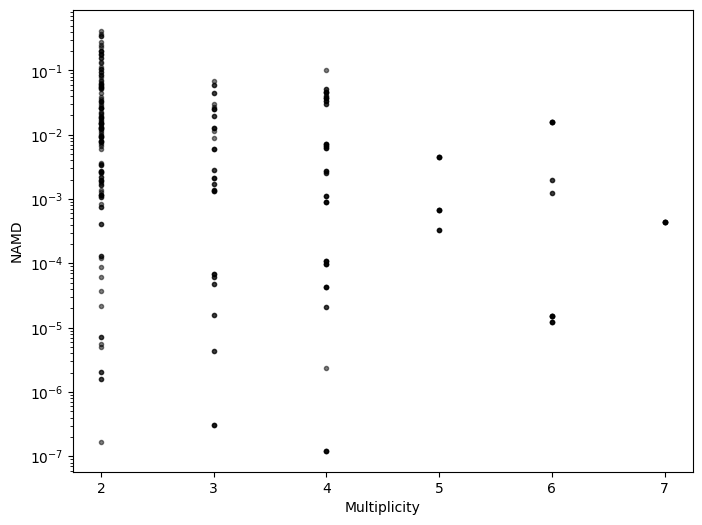

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(df_clean_relincl_good["sy_pnum"], df_clean_relincl_good["namd"], '.', c="k", alpha=0.5)
plt.yscale("log")
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.show()

In [23]:
namd_relincl_good = namd_loop(df_clean_relincl_good)

namd_relincl_good

56


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
1,BD-210397,0.042004,0.033968,0.023168,2.0,0,0.680126
2,CoRoT-20,0.182254,0.010711,0.010204,2.0,0,0.057379
7,GJ 676 A,0.053531,0.013701,0.01128,4.0,"[0, 0]",0.233332
8,GJ 876,0.007637,0.000532,0.000289,4.0,"[0, 0, 0, 0]",0.053781
9,HAT-P-11,0.240755,0.095559,0.040031,2.0,"[0, 0]",0.281593
...,...,...,...,...,...,...,...
145,V1298 Tau,0.043381,0.026062,0.019145,4.0,"[0, 0]",0.521045
147,WASP-148,0.070457,0.022591,0.018521,2.0,"[0, 0]",0.291759
150,WASP-8,0.048178,0.001061,0.001042,2.0,0,0.021826
151,bet Pic,0.016671,0.005919,0.004443,2.0,"[0, 0]",0.310785


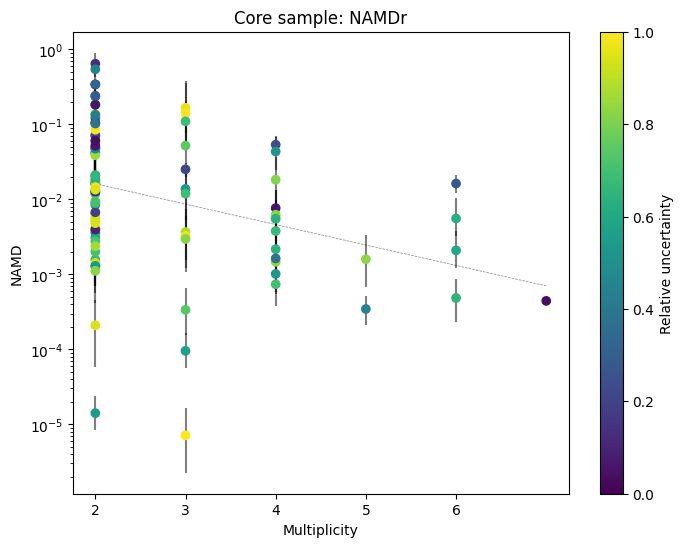

In [24]:
# plot the NAMD vs N and color by the relative uncertainty
namd_relincl_plot = namd_relincl_good.copy()
# sort columns by multiplicity
namd_relincl_plot = namd_relincl_plot.sort_values(by="N")
namd_relincl_plot.drop(columns=["flag", "hostname"], inplace=True)
# make the whole DataFrame numeric
namd_relincl_plot = namd_relincl_plot.apply(pd.to_numeric)

# plot the NAMD vs N and color by the relative uncertainty
plt.figure(figsize=(8, 6))
plt.errorbar(namd_relincl_plot["N"], namd_relincl_plot["namd"], 
             yerr=[namd_relincl_plot["namd_err2"], namd_relincl_plot["namd_err1"]], 
             fmt="none", c="k", alpha=0.5)
s = plt.scatter(namd_relincl_plot["N"], namd_relincl_plot["namd"], c=namd_relincl_plot["relative_uncertainty"], cmap="viridis", zorder=10)

coeffs = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1)
plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(coeffs, namd_relincl_plot["N"]), 'k--', zorder=5, alpha=0.5, lw=0.5)

namd_err_avg = (namd_relincl_plot["namd_err1"] + namd_relincl_plot["namd_err2"]) / 2
# popt, pcov = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1, cov=True, w=1/(namd_err_avg/namd_relincl_plot["namd"] * np.log(10)))
# plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(popt, namd_relincl_plot["N"]), 'k-', zorder=5, alpha=0.5, lw=0.5)
# print(popt, np.sqrt(np.diag(pcov)))

# from scipy.optimize import curve_fit
# def func(x, a, b):
#     return a * x + b
# popt, pcov = curve_fit(func, namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), sigma=namd_err_avg/namd_relincl_plot["namd"] * np.log(10), absolute_sigma=True)
# plt.plot(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], *popt), 'r-', zorder=5, alpha=0.5, lw=0.5)
# aerr = np.sqrt(pcov[0, 0])
# berr = np.sqrt(pcov[1, 1])
# plt.fill_between(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], popt[0] - aerr, popt[1] - berr), 10 ** func(namd_relincl_plot["N"], popt[0] + aerr, popt[1] + berr), color="r", alpha=0.2)

plt.colorbar(s, label="Relative uncertainty")
plt.clim(0, 1)
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.title("Core sample: NAMDr")
plt.xticks(range(2, 7))
plt.savefig("namdr_core_sample.pdf", dpi=300, bbox_inches="tight")
plt.show()

# print(popt, np.sqrt(np.diag(pcov)))

In [25]:
namd_relincl = namd_loop(df_clean_relincl)

namd_relincl

89


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
0,24 Sex,0.021625,0.019229,0.012282,2.0,"[03, 03]",0.728602
1,47 UMa,0.021798,0.027039,0.015155,3.0,"[03, 03, 03]",0.967828
3,61 Vir,0.04301,0.02456,0.018458,3.0,"[03, 03, 03]",0.500098
4,7 CMa,0.008449,0.007506,0.004838,2.0,"[03+3-, 03+3-]",0.73054
5,75 Cet,0.005461,0.004408,0.002964,2.0,"[03, 03]",0.674916
...,...,...,...,...,...,...,...
834,iot Dra,0.235177,0.140143,0.08322,2.0,"[0, 0]",0.474883
835,nu Oph,0.013426,0.000817,0.000781,2.0,"[03+3-, 03+3-]",0.059521
836,rho CrB,0.000786,0.000309,0.000193,4.0,"[01+1-3, 03, 03, 03]",0.319273
837,tau Cet,0.023073,0.019421,0.012247,4.0,"[03, 03, 03, 03]",0.686269


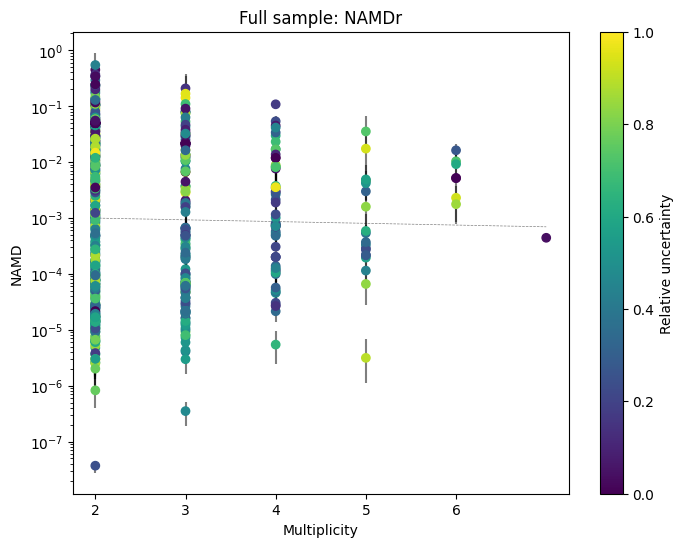

In [26]:
# plot the NAMD vs N and color by the relative uncertainty
namd_relincl_plot = namd_relincl.copy()
namd_relincl_plot.drop(columns=["flag", "hostname"], inplace=True)
# make the whole DataFrame numeric
namd_relincl_plot = namd_relincl_plot.apply(pd.to_numeric)
# sort columns by multiplicity
namd_relincl_plot = namd_relincl_plot.sort_values(by="N")

# plot the NAMD vs N and color by the relative uncertainty
plt.figure(figsize=(8, 6))
plt.errorbar(namd_relincl_plot["N"], namd_relincl_plot["namd"], yerr=[namd_relincl_plot["namd_err2"], namd_relincl_plot["namd_err1"]], fmt="none", c="k", alpha=0.5)
s = plt.scatter(namd_relincl_plot["N"], namd_relincl_plot["namd"], c=namd_relincl_plot["relative_uncertainty"], cmap="viridis", zorder=10)

coeffs = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1)
plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(coeffs, namd_relincl_plot["N"]), 'k--', zorder=5, alpha=0.5, lw=0.5)
# namd_err_avg = (namd_relincl_plot["namd_err1"] + namd_relincl_plot["namd_err2"]) / 2
# popt, pcov = curve_fit(func, namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), sigma=namd_err_avg/namd_relincl_plot["namd"] * np.log(10), absolute_sigma=True)
# plt.plot(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], *popt), 'r-', zorder=5, alpha=0.5, lw=0.5)

plt.colorbar(s, label="Relative uncertainty")
plt.clim(0, 1)
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.title("Full sample: NAMDr")
plt.xticks(range(2, 7))
plt.savefig("namdr_full_sample.pdf", dpi=300, bbox_inches="tight")
plt.show()

Some plotting

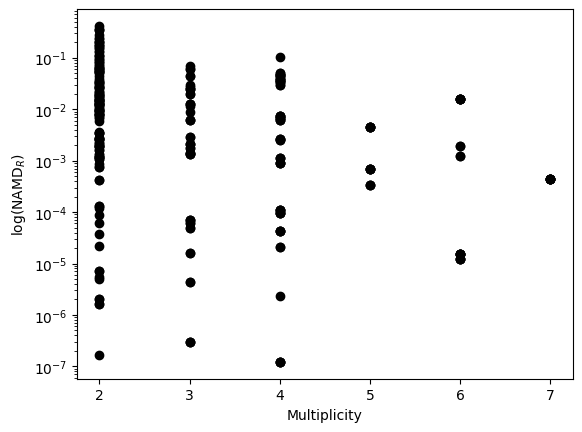

In [27]:
# plot the NAMD vs. multiplicity for all the planets with flag 0
idx = df_clean_relincl["flag"] == "0"
plt.figure()
plt.scatter(df_clean_relincl[idx]["sy_pnum"], df_clean_relincl[idx]["namd"], c="k")
plt.xlabel("Multiplicity")
plt.ylabel("log(NAMD$_R$)")
plt.yscale("log")
plt.grid(False)
plt.show()

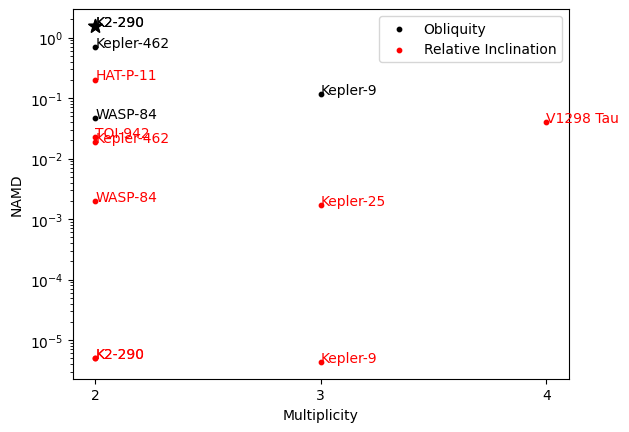

In [28]:
# plot the NAMD vs multiplicity for the planets with obliquity

plt.figure()
idx = df_clean_obliquity["pl_trueobliq"].notnull()
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=10, label="Obliquity")
# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_obliquity[idx]["hostname"]):
    plt.annotate(txt, (df_clean_obliquity[idx]["sy_pnum"].values[i], df_clean_obliquity[idx]["namd"].values[i]), color="k")

# mark with a star the system K2-290
idx = df_clean_obliquity["hostname"] == "K2-290"
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=100, marker="*") #, label="K2-290")

# now for the planets with relative inclination
# trueobliq_notnull = df_clean_relincl["pl_trueobliq"].notnull()
plt.scatter(df_clean_relincl[trueobliq_notnull]["sy_pnum"], df_clean_relincl[trueobliq_notnull]["namd"], c="r", s=10, label="Relative Inclination")

# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_relincl[trueobliq_notnull]["hostname"]):
    plt.annotate(txt, (df_clean_relincl[trueobliq_notnull]["sy_pnum"].values[i], df_clean_relincl[trueobliq_notnull]["namd"].values[i]), color="r")

plt.legend()
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.xticks(np.arange(2, 5))
plt.show()

In [29]:
df[df["hostname"] == "Kepler-9"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
2197,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,0.0,0.00055,-0.00056,89.1,0.1,-0.1,NaN,NaN,NaN,0
2203,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,0.0,0.00000,0.00000,89.4,0.2,-0.3,NaN,NaN,NaN,01+1-3+3-
2282,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,0.0,0.00100,-0.00130,88.9,0.1,-0.2,28.1,13.0,-13.6,0


TOI-942 benchmark

In [30]:
df_clean_relincl[df_clean_relincl["hostname"] == "TOI-942"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
4124,TOI-942 b,TOI-942,1.0,0.04866,0.0007,-0.00065,16.0,0.0,0.0,2.0,...,-0.1195,89.966,0.34,-0.51,02+2-,-0.766,0.689638,-0.660681,0.146677,0.022573
4125,TOI-942 c,TOI-942,1.0,0.08598,0.0012,-0.00110,32.0,0.0,0.0,2.0,...,-0.1315,89.200,0.60,-0.42,02+2-,0.000,0.848528,-0.593970,0.144797,0.022573


In [31]:
userid = "TOI-942"
toi942_idx = df_clean_relincl[df_clean_relincl["hostname"] == userid].index
df_userid = df_clean_relincl.loc[toi942_idx]

# df.loc[1925, df.columns] = ["TOI-942b", "TOI-942", 0.0498, 0.0007, -0.0007, 21, 4, -4, 2, 0.285, 0.133, -0.099, 88.6, 1.0, -1.0]
# df.loc[1926, df.columns] = ["TOI-942c", "TOI-942", 0.0880, 0.0014, -0.0014, 27, 5, -5, 2, 0.175, 0.139, -0.103, 89.2, 0.6, -0.6]

In [32]:
df_userid.loc[toi942_idx, "pl_orbsmax"] = [0.0880, 0.0498]
df_userid.loc[toi942_idx, "pl_orbsmaxerr1"] = [0.0014, 0.0007]
df_userid.loc[toi942_idx, "pl_orbsmaxerr2"] = [-0.0014, -0.0007]
df_userid.loc[toi942_idx, "pl_bmasse"] = [27.0, 21.0]
df_userid.loc[toi942_idx, "pl_bmasseerr1"] = [5.0, 4.0]
df_userid.loc[toi942_idx, "pl_bmasseerr2"] = [-5.0, -4.0]
df_userid.loc[toi942_idx, "pl_orbeccen"] = [0.175, 0.285]
df_userid.loc[toi942_idx, "pl_orbeccenerr1"] = [0.139, 0.133]
df_userid.loc[toi942_idx, "pl_orbeccenerr2"] = [-0.103, -0.099]
df_userid.loc[toi942_idx, "pl_orbincl"] = [89.2, 88.6]
df_userid.loc[toi942_idx, "pl_orbinclerr1"] = [0.6, 1.0]
df_userid.loc[toi942_idx, "pl_orbinclerr2"] = [-0.6, -1.0]
maxmass_toi942 = df_userid["pl_bmasse"].idxmax()
df_userid.loc[toi942_idx, "pl_relincl"] = df_userid.loc[maxmass_toi942, "pl_orbincl"] - df_userid["pl_orbincl"]
df_userid.loc[toi942_idx, "pl_relinclerr1"] = np.sqrt(df_userid.loc[maxmass_toi942, "pl_orbinclerr1"]**2 + df_userid["pl_orbinclerr1"]**2)
df_userid.loc[toi942_idx, "pl_relinclerr2"] = np.sqrt(df_userid.loc[maxmass_toi942, "pl_orbinclerr2"]**2 + df_userid["pl_orbinclerr2"]**2)

Plotting...


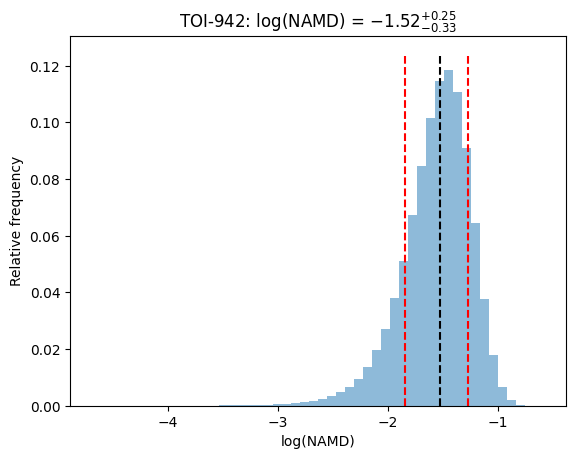

{'q16': 0.014230661693237164,
 'q50': 0.030158979559723555,
 'q84': 0.053776569627380574,
 'N': 2.0}

In [33]:
Npt = 1000000
compute_namd(userid, df_userid, Npt)

In [34]:
df_userid = df_userid[df_userid.columns.drop([
    # "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2", 
    "flag", "amd", "namd"])]
df_userid.to_csv("TOI-942.csv")

In [35]:
df_userid.columns

Index(['pl_name', 'hostname', 'default_flag', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'sy_pnum', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
       'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_relincl',
       'pl_relinclerr1', 'pl_relinclerr2'],
      dtype='object')

K2-290 benchmark

In [36]:
df_k2290 = df_clean_obliquity[df_clean_obliquity["hostname"] == "K2-290"]

In [37]:
df_k2290[["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2", "pl_relincl", "pl_relinclerr1", "pl_relinclerr2", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_relincl,pl_relinclerr1,pl_relinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2
16891,88.20,0.50,-0.60,127.0,42.0,-50.0,127.0,42.0,-50.0
1764,89.37,0.08,-0.07,124.0,6.0,-6.0,124.0,6.0,-6.0


In [38]:
Npt = 1000000
userid = "K2-290"

k2290_idx = df_clean_relincl[df_clean_relincl["hostname"] == userid].index
df_userid = df_clean_relincl.loc[k2290_idx]

k2290_namdr = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

k2290_idx = df_clean_obliquity[df_clean_obliquity["hostname"] == userid].index
df_userid = df_clean_obliquity.loc[k2290_idx]

k2290_namda = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

In [39]:
def plot_namd_hist(userid, userid_namd_r, userid_namd_a, ndigits = (0, 4)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    log_namd = np.log10(userid_namd_r["samples"]["namd"])
    log_quantiles = log_namd.quantile([0.16, 0.5, 0.84])
    weights = np.ones_like(log_namd) / len(log_namd)
    ax1.hist(log_namd, bins=50, alpha=0.5, weights=weights)
    ax1.vlines(log_quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
    ax1.set_ylabel("Relative frequency")
    ax1.set_xlabel(rf"log(NAMDr)")
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks())
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"%.{ndigits[0]}f" % x))

    title = f"{userid}: " + rf"log(NAMDr) = ${log_quantiles[0.5]:.2f}^{{+{log_quantiles[0.84]-log_quantiles[0.5]:.2f}}}_{{-{log_quantiles[0.5]-log_quantiles[0.16]:.2f}}}$"
    ax1.set_title(title)

    log_namda = np.log10(userid_namd_a["samples"]["namd"])
    log_quantiles = log_namda.quantile([0.16, 0.5, 0.84])
    weights = np.ones_like(log_namda) / len(log_namda)
    ax2.hist(log_namda, bins=50, alpha=0.5, weights=weights)
    ax2.vlines(log_quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
    ax2.set_xlabel(rf"log(NAMDa)")

    title = f"{userid}: " + rf"log(NAMDa) = ${log_quantiles[0.5]:.4f}^{{+{log_quantiles[0.84]-log_quantiles[0.5]:.4f}}}_{{-{log_quantiles[0.5]-log_quantiles[0.16]:.4f}}}$"
    ax2.set_title(title)

    # hide the spines between ax and ax2
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.tick_params(labelright="off")
    ax2.yaxis.tick_right()

    ax2.set_xticks(ax2.get_xticks())
    ax2.set_xticklabels(ax2.get_xticks())
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"%.{ndigits[1]}f" % x))

    d = 0.015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((-d, +d), (-d, +d), **kwargs)

    plt.savefig(f"{userid}_namd.pdf", dpi=300, bbox_inches="tight")
    plt.show()

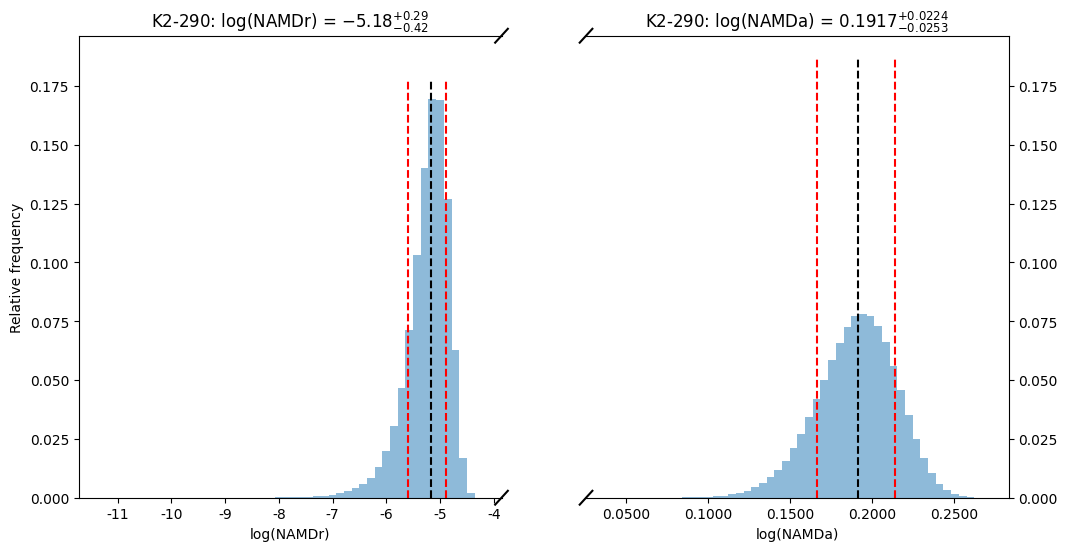

In [40]:
plot_namd_hist("K2-290", k2290_namdr, k2290_namda)

trueoblmm_hostnames

In [41]:
df_namd_obliquity_trueoblmm_hostnames = df_clean_obliquity[df_clean_obliquity["hostname"].isin(trueoblmm_hostnames)]

namd_obliquity_trueoblmm_hostnames = namd_loop(df_namd_obliquity_trueoblmm_hostnames)

print(namd_obliquity_trueoblmm_hostnames)

# for each hostname, print: 
# hostname  &   namd$_r^{+err}_{-err}$    &  relative_uncertainty in %

for hostname in namd_obliquity_trueoblmm_hostnames["hostname"].unique():
    idx = namd_obliquity_trueoblmm_hostnames["hostname"] == hostname
    namd = namd_obliquity_trueoblmm_hostnames[idx]["namd"]
    namd_err1 = namd_obliquity_trueoblmm_hostnames[idx]["namd_err1"]
    namd_err2 = namd_obliquity_trueoblmm_hostnames[idx]["namd_err2"]
    print(f"{hostname} & ${namd.values[0]:.3f}^{{+{namd_err1.values[0]:.3f}}}_{{-{namd_err2.values[0]:.3f}}}$ & {100 * namd_obliquity_trueoblmm_hostnames[idx]['relative_uncertainty'].values[0]:.2f}")

0
     hostname      namd namd_err1 namd_err2    N               flag  \
0  Kepler-462  0.700825  0.042566  0.043359  2.0         [03+3-, 0]   
1    Kepler-9  0.131111  0.086809  0.064106  3.0  [01+1-3+3-, 0, 0]   
2     WASP-84  0.047408  0.046441  0.030059  2.0        [01+1-, 01]   

  relative_uncertainty  
0             0.061303  
1             0.575525  
2             0.806824  
Kepler-462 & $0.701^{+0.043}_{-0.043}$ & 6.13
Kepler-9 & $0.131^{+0.087}_{-0.064}$ & 57.55
WASP-84 & $0.047^{+0.046}_{-0.030}$ & 80.68


In [42]:
df_namd_relincl_trueoblmm_hostnames = df_clean_relincl[df_clean_relincl["hostname"].isin(trueoblmm_hostnames)]

def namd_loop(df: pd.DataFrame, Npt: int = 100000):

    df_namd = pd.DataFrame(columns=["hostname", "namd", "namd_err1", "namd_err2", "N", "flag", "relative_uncertainty"])
    for k, name in enumerate(df.hostname.unique()):
        df_namd.loc[k, "hostname"] = name
        df_namd.loc[k, "flag"] = df[df["hostname"] == name]["flag"].values
        retval = compute_namd(name, df, Npt=Npt, do_plot=False)
        df_namd.loc[k, "namd"] = retval["q50"]
        df_namd.loc[k, "namd_err1"] = retval["q84"] - retval["q50"]
        df_namd.loc[k, "namd_err2"] = retval["q50"] - retval["q16"]
        df_namd.loc[k, "N"] = retval["N"]
        df_namd.loc[k, "relative_uncertainty"] = (retval["q84"] - retval["q16"]) / 2 / retval["q50"]

    # drop nans
    df_namd = df_namd.dropna()
    # # drop where relative uncertainty is greater than 1
    # remove_large_uncertainty = df_namd["relative_uncertainty"] > 1
    # print(len(df_namd[remove_large_uncertainty]))
    # df_namd = df_namd[~remove_large_uncertainty]

    return df_namd

namd_relincl_trueoblmm_hostnames = namd_loop(df_namd_relincl_trueoblmm_hostnames)

for hostname in namd_relincl_trueoblmm_hostnames["hostname"].unique():
    idx = namd_relincl_trueoblmm_hostnames["hostname"] == hostname
    namd = namd_relincl_trueoblmm_hostnames[idx]["namd"]
    namd_err1 = namd_relincl_trueoblmm_hostnames[idx]["namd_err1"]
    namd_err2 = namd_relincl_trueoblmm_hostnames[idx]["namd_err2"]
    print(f"{hostname} & ${namd.values[0]:.6f}^{{+{namd_err1.values[0]:.6f}}}_{{-{namd_err2.values[0]:.6f}}}$ & {100 * namd_relincl_trueoblmm_hostnames[idx]['relative_uncertainty'].values[0]:.0f}")

namd_relincl_trueoblmm_hostnames

Kepler-462 & $0.019273^{+0.028984}_{-0.011971}$ & 106
Kepler-9 & $0.000009^{+0.000009}_{-0.000005}$ & 80
WASP-84 & $0.001954^{+0.000555}_{-0.000549}$ & 28


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
0,Kepler-462,0.019273,0.028984,0.011971,2.0,"[03+3-, 0]",1.062474
1,Kepler-9,0.000009,0.000009,0.000005,3.0,"[01+1-3+3-, 0, 0]",0.801418
2,WASP-84,0.001954,0.000555,0.000549,2.0,"[01+1-, 01]",0.282279


In [43]:
df_clean_relincl[df_clean_relincl["hostname"].isin(trueoblmm_hostnames)]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
4785,Kepler-462 c,Kepler-462,1.0,0.86000,0.00000,0.00000,6.00000,10.80000,-4.90000,2.0,...,-0.09000,90.640,0.06,-0.06,03+3-,-1.300,0.078102,-0.078102,0.746698,0.018877
3581,Kepler-462 b,Kepler-462,1.0,0.47310,0.00000,0.00000,53.90000,104.60000,-23.80000,2.0,...,-0.01900,89.340,0.05,-0.05,0,0.000,0.070711,-0.070711,0.058177,0.018877
2203,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,...,0.00000,89.400,0.20,-0.30,01+1-3+3-,-0.500,0.223607,-0.360555,0.000053,0.000004
2282,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,...,-0.00130,88.900,0.10,-0.20,0,0.000,0.141421,-0.282843,0.000000,0.000004
2197,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,...,-0.00056,89.100,0.10,-0.10,0,-0.200,0.141421,-0.223607,0.000087,0.000004
275,WASP-84 b,WASP-84,1.0,0.07730,0.00145,-0.00145,220.28250,13.03103,-12.71320,2.0,...,0.00000,88.368,0.05,-0.05,01+1-,0.000,0.070711,-0.070711,0.000000,0.001959
2127,WASP-84 c,WASP-84,1.0,0.02359,0.00100,-0.00100,15.20000,4.50000,-4.20000,2.0,...,0.00000,83.200,0.51,-0.49,01,5.168,0.512445,-0.492544,0.124535,0.001959


In [44]:
df_clean_obliquity[df_clean_obliquity["hostname"].isin(trueoblmm_hostnames)]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
4785,Kepler-462 c,Kepler-462,1.0,0.86000,0.00000,0.00000,6.00000,10.80000,-4.90000,2.0,...,-0.06,NaN,NaN,NaN,03+3-,72.0,3.0,-3.0,4.075107,0.696807
3581,Kepler-462 b,Kepler-462,1.0,0.47310,0.00000,0.00000,53.90000,104.60000,-23.80000,2.0,...,-0.05,72.0,3.0,-3.0,0,72.0,3.0,-3.0,25.635234,0.696807
2203,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,...,-0.30,NaN,NaN,NaN,01+1-3+3-,28.1,13.0,-13.6,0.162980,0.117873
2282,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,...,-0.20,28.1,13.0,-13.6,0,28.1,13.0,-13.6,1.936046,0.117873
2197,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,...,-0.10,NaN,NaN,NaN,0,28.1,13.0,-13.6,1.679741,0.117873
275,WASP-84 b,WASP-84,1.0,0.07730,0.00145,-0.00145,220.28250,13.03103,-12.71320,2.0,...,-0.05,17.3,7.7,-7.7,01+1-,17.3,7.7,-7.7,2.770669,0.046974
2127,WASP-84 c,WASP-84,1.0,0.02359,0.00100,-0.00100,15.20000,4.50000,-4.20000,2.0,...,-0.49,NaN,NaN,NaN,01,17.3,7.7,-7.7,0.215903,0.046974


Histograms for Kepler-462

In [45]:
Npt = 1000000
userid = "Kepler-462"

kepler462_idx = df_clean_relincl[df_clean_relincl["hostname"] == userid].index
df_userid = df_clean_relincl.loc[kepler462_idx]

kepler462_namdr = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

kepler462_idx = df_clean_obliquity[df_clean_obliquity["hostname"] == userid].index
df_userid = df_clean_obliquity.loc[kepler462_idx]

kepler462_namda = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

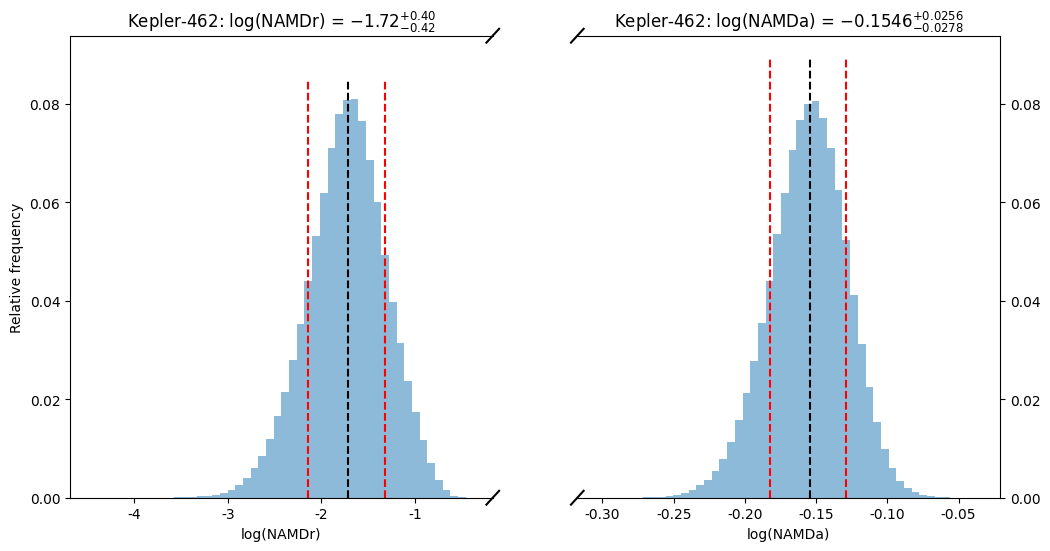

In [46]:
plot_namd_hist("Kepler-462", kepler462_namdr, kepler462_namda, ndigits=(0, 2))
